In [ ]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
data = read_text("/content/drive/MyDrive/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng = deu_eng[:50000,:]

#**Text Preprocessing**

In [ ]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["I'm glad you're glad.", 'Ich freue mich, dass Sie sich freuen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3396771 (CK) & #3405621 (Pfirsichbaeumchen)'],
       ["I'm glad you're here.", 'Ich bin froh, dass du hier bist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #782823 (Chris)'],
       ["I'm glad you're here.", 'Ich bin froh, dass ihr hier seid.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #8483032 (Luiaard)']],
      dtype='<U537')

In [ ]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()

    deu_eng[i,1] = deu_eng[i,1].lower()

In [ ]:
deu_eng

array([['go.', 'geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi.', 'hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi.', 'grüß gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["i'm glad you're glad.", 'ich freue mich, dass sie sich freuen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3396771 (CK) & #3405621 (Pfirsichbaeumchen)'],
       ["i'm glad you're here.", 'ich bin froh, dass du hier bist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #782823 (Chris)'],
       ["i'm glad you're here.", 'ich bin froh, dass ihr hier seid.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #8483032 (Luiaard)']],
      dtype='<U537')

In [ ]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

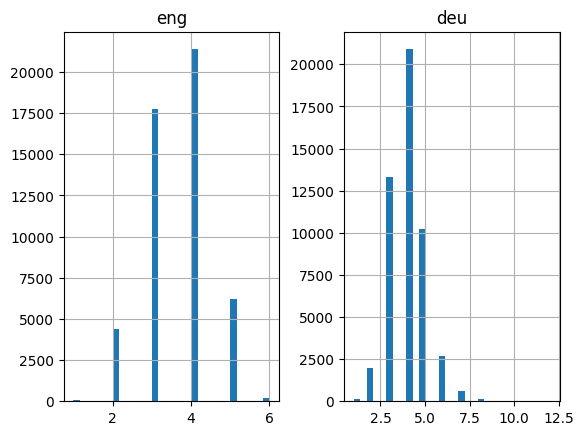

In [ ]:
length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6088


In [ ]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10082


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

##**Model Building**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=30, batch_size=512,
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 4.2148
Epoch 1: val_loss improved from inf to 3.13497, saving model to model.h1.24_jan_19
63/63 [==============================] - 26s 289ms/step - loss: 4.2148 - val_loss: 3.1350
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.8767
Epoch 2: val_loss improved from 3.13497 to 2.77564, saving model to model.h1.24_jan_19
63/63 [==============================] - 16s 252ms/step - loss: 2.8767 - val_loss: 2.7756
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.7387
Epoch 3: val_loss improved from 2.77564 to 2.71096, saving model to model.h1.24_jan_19
63/63 [==============================] - 15s 241ms/step - loss: 2.7387 - val_loss: 2.7110
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.6926
Epoch 4: val_loss improved from 2.71096 to 2.68483, saving model to model.h1.24_jan_19
63/63 [==============================] - 14s 222ms/step - loss: 2.6926 - val_loss: 2.6

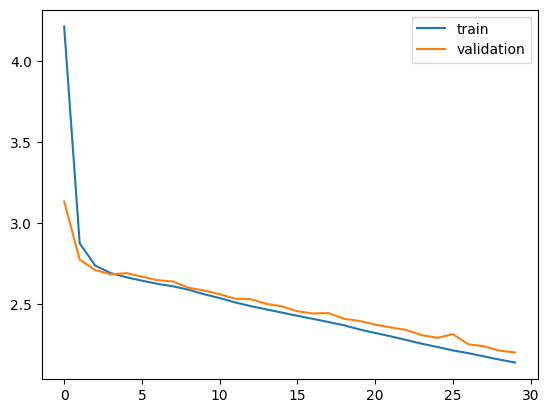

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

##**Get Prediction Results**

In [ ]:
model = load_model('model.h1.24_jan_19')
pred_probs = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))
preds = argmax(pred_probs, axis=-1)

313/313 [==============================] - 3s 6ms/step


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if np.array_equal(index, n):
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)

        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,see you in october.,we not a
1,tom bowed.,tom was
2,tom bent down.,tom was
3,it's too ugly.,it's is a
4,tom decided to stay.,tom has a
5,i think they saw us.,i want you
6,what's stopping you?,how you
7,it's very hot today.,it's a
8,do you feel sick?,you
9,she became very ill.,she you a


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,do they work here?,please you
9986,they won't care.,how was a
9987,tom almost smiled.,tom has a
9988,here's your coffee.,the
9989,tom told me that.,tom can't me
9990,i don't cook well.,i have you
9991,what did he say?,how did tom
9992,tom drives.,tom was
9993,tom was never here.,tom has a
9994,get off my lawn.,the is


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,do they work here?,please you
9986,they won't care.,how was a
9987,tom almost smiled.,tom has a
9988,here's your coffee.,the
9989,tom told me that.,tom can't me
9990,i don't cook well.,i have you
9991,what did he say?,how did tom
9992,tom drives.,tom was
9993,tom was never here.,tom has a
9994,get off my lawn.,the is


In [ ]:
pred_df.sample(15)

,actual,predicted
3577,tom was very rude.,tom was a
4832,i can't find my bag.,i can't to it
5723,they never stopped.,you have
9743,you were rushing.,you
9968,i like being home.,i'm not a
9769,it's scorching hot.,it was
8166,i caught two fish.,i like you
3593,it'll work for sure.,it was
3590,i have good reflexes.,i have a
7521,i'm first in line.,i'm not a
